# Evaluating and explaining classifiers

Code lightly adapted from [*Practical Machine Learning with Python*, chapter 5](https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/notebooks/Ch05_Building_Tuning_and_Deploying_Models) by Dipanjan Sarkar.

# Load Wisconsin breast cancer dataset

These are features of diagnostic tissue imaging tests. Note that label coding is: `0 = malignant`, `1 = benign`.

In [39]:
from sklearn.datasets import load_breast_cancer

# load data
data = load_breast_cancer()
X = data.data
y = data.target
print("Data shape:", X.shape)
print("Features:", data.feature_names)

Data shape: (569, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


## Standardize features

Compare results with and without feature normalization ...

In [40]:
from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(X)

# Clustering with *k*-Means

In [41]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=2)
km.fit(X)

labels = km.labels_
centers = km.cluster_centers_
print(labels[100:110])

[0 0 0 0 0 0 0 0 1 0]


In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
bc_pca = pca.fit_transform(X)

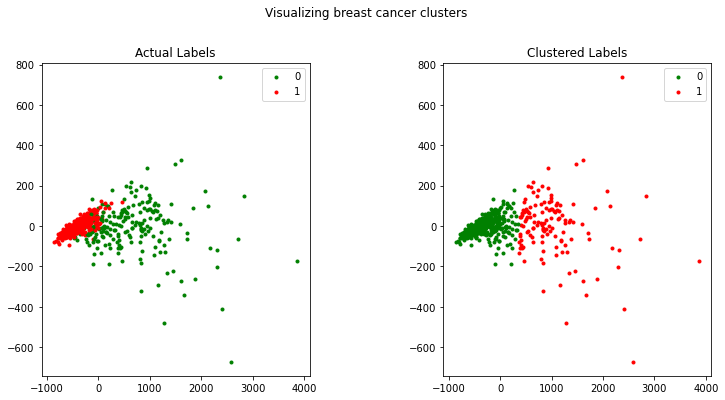

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Visualizing breast cancer clusters')
fig.subplots_adjust(top=0.85, wspace=0.5)
ax1.set_title('Actual Labels')
ax2.set_title('Clustered Labels')

for i in range(len(y)):
    if y[i] == 0:
        c1 = ax1.scatter(bc_pca[i,0], bc_pca[i,1],c='g', marker='.')
    if y[i] == 1:
        c2 = ax1.scatter(bc_pca[i,0], bc_pca[i,1],c='r', marker='.')
        
    if labels[i] == 0:
        c3 = ax2.scatter(bc_pca[i,0], bc_pca[i,1],c='g', marker='.')
    if labels[i] == 1:
        c4 = ax2.scatter(bc_pca[i,0], bc_pca[i,1],c='r', marker='.')

l1 = ax1.legend([c1, c2], ['0', '1'])
l2 = ax2.legend([c3, c4], ['0', '1'])

# Classification with logistic regression

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(398, 30) (171, 30)


In [45]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression(max_iter=10000)
logistic.fit(X_train,y_train)
y_pred = logistic.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix
print("Accuracy:", logistic.score(X_test, y_test))
print("Confusion matrix:")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.9766081871345029
Confusion matrix:


array([[ 61,   2],
       [  2, 106]])

In [47]:
logistic.coef_

array([[ 1.05650040e+00,  2.33176754e-01, -3.95224445e-01,
         2.63431164e-02, -1.39423723e-01, -2.38427824e-01,
        -5.20595658e-01, -2.79974382e-01, -2.21306084e-01,
        -3.89172017e-02, -1.22558401e-01,  1.38015124e+00,
         4.44825385e-01, -1.45415147e-01, -1.88065889e-02,
         9.19391564e-03, -6.65701558e-02, -3.59515422e-02,
        -4.35490678e-02,  9.28192546e-04,  4.77361279e-02,
        -5.09190273e-01, -5.73194268e-02, -1.12071814e-02,
        -2.81369228e-01, -7.26797273e-01, -1.36420736e+00,
        -5.06697764e-01, -7.20209558e-01, -1.00756618e-01]])

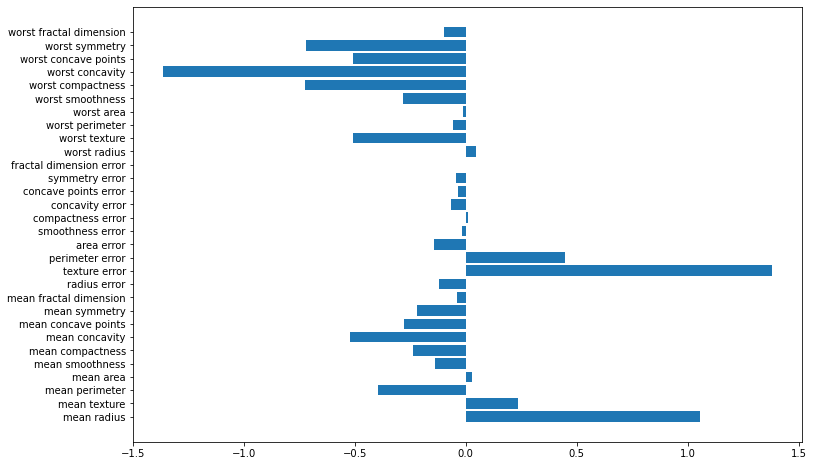

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
plt.barh(list(range(X.shape[1])),logistic.coef_[0], tick_label=data.feature_names)
plt.show()

# Feature importance via permutation

In [49]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    logistic, X_test, y_test,
    n_repeats=30, random_state=0
)

print("Permutation feature importance:\n")

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data.feature_names[i]:<8}"
        f"\t{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

Permutation feature importance:

mean perimeter	0.423 +/- 0.035
worst area	0.247 +/- 0.031
area error	0.152 +/- 0.025
worst texture	0.109 +/- 0.019
mean area	0.093 +/- 0.018
worst perimeter	0.047 +/- 0.015
mean radius	0.039 +/- 0.010
mean texture	0.018 +/- 0.007
texture error	0.012 +/- 0.006
worst concavity	0.010 +/- 0.005


# Model interpretation with `skater`

In [50]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_test, feature_names=data.feature_names)
model = InMemoryModel(logistic.predict_proba, examples=X_train, target_names=logistic.classes_)

## Visualize feature importances

[30/30] features ████████████████████ Time elapsed: 0 seconds

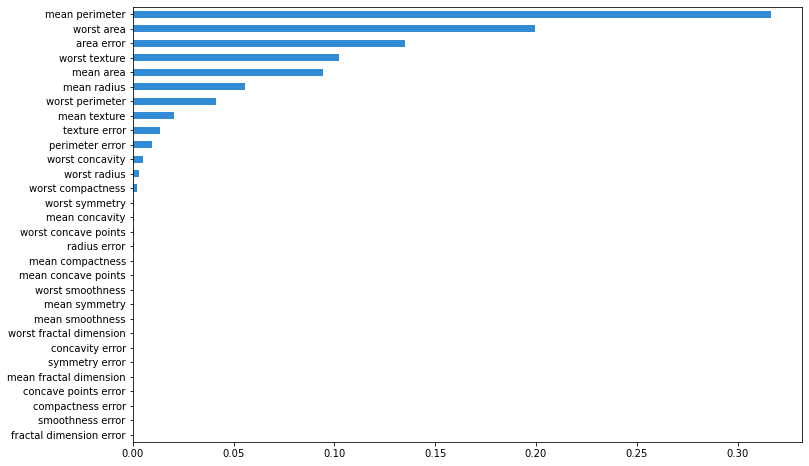

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=False, ax=ax)

## One-way partial dependence plot

[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

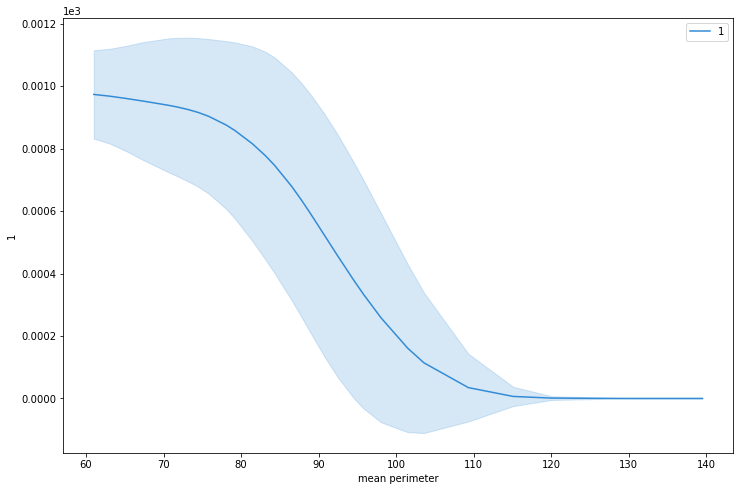

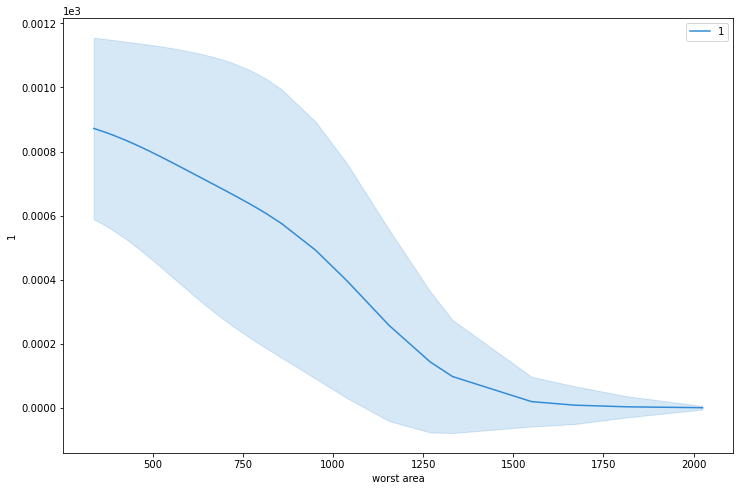

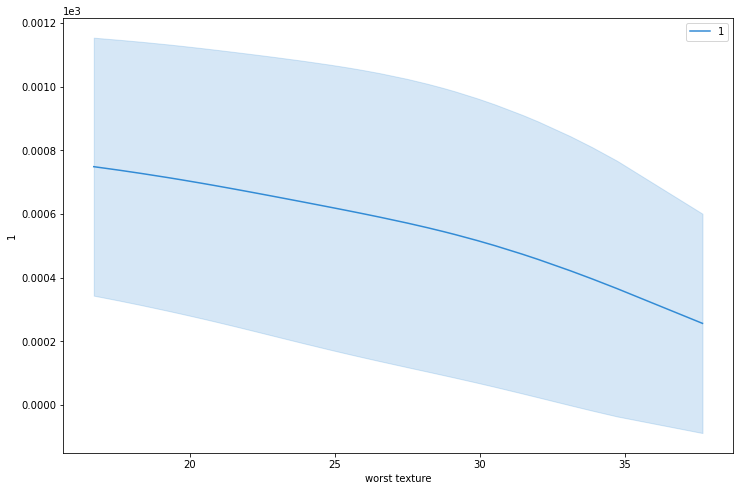

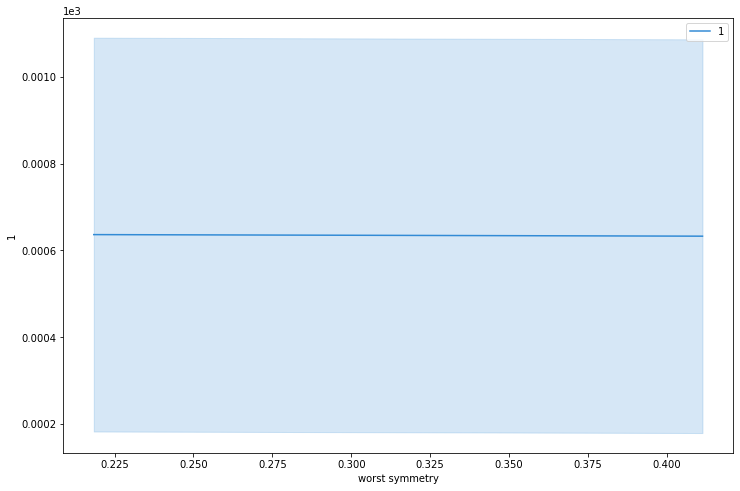

In [52]:
p = interpreter.partial_dependence.plot_partial_dependence(
    ['mean perimeter', 'worst area', 'worst texture', 'worst symmetry'], 
    model, 
    n_samples=200,
    with_variance=True, 
    figsize = (12, 8)
)

## Explaining individual predictions

In [53]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_train, feature_names=data.feature_names, 
                           discretize_continuous=True, class_names=['0', '1'])

In [54]:
exp.explain_instance(X_test[0], logistic.predict_proba).show_in_notebook()

In [55]:
exp.explain_instance(X_test[1], logistic.predict_proba).show_in_notebook()